Texas power forecast project

In [63]:
from random import gauss as gs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

import itertools
#from pmdarima import auto_arima

#statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX


%matplotlib inline

# Exploring 

In [2]:
! ls ../Data/texasPowerGrid.csv

../Data/texasPowerGrid.csv


In [40]:
texas = pd.read_csv('../Data/texasPowerGrid.csv')

In [41]:
texas.set_index(pd.to_datetime(texas['UTC Time at End of Hour']), inplace=True)
texas

,Unnamed: 0,Balancing Authority,Data Date,Hour Number,Local Time at End of Hour,UTC Time at End of Hour,Demand Forecast (MW),Demand (MW),Net Generation (MW),Total Interchange (MW),...,Region,Net Generation (MW) from Coal,Net Generation (MW) from Natural Gas,Net Generation (MW) from Nuclear,Net Generation (MW) from All Petroleum Products,Net Generation (MW) from Hydropower and Pumped Storage,Net Generation (MW) from Solar,Net Generation (MW) from Wind,Net Generation (MW) from Other Fuel Sources,Net Generation (MW) from Unknown Fuel Sources
UTC Time at End of Hour,,,,,,,,,,,,,,,,,,,,,
2018-01-01 07:00:00,65148,ERCO,01/01/2018,1,01/01/2018 1:00:00 AM,01/01/2018 7:00:00 AM,"47,834","50,587","50,800",212,...,TEX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 08:00:00,65149,ERCO,01/01/2018,2,01/01/2018 2:00:00 AM,01/01/2018 8:00:00 AM,"48,313","50,650","51,036",385,...,TEX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 09:00:00,65150,ERCO,01/01/2018,3,01/01/2018 3:00:00 AM,01/01/2018 9:00:00 AM,"49,513","50,737","50,887",150,...,TEX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 10:00:00,65151,ERCO,01/01/2018,4,01/01/2018 4:00:00 AM,01/01/2018 10:00:00 AM,"48,663","51,021","51,419",398,...,TEX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 11:00:00,65152,ERCO,01/01/2018,5,01/01/2018 5:00:00 AM,01/01/2018 11:00:00 AM,"50,639","51,727","52,048",321,...,TEX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-06 02:00:00,56839,ERCO,12/05/2022,20,12/05/2022 8:00:00 PM,12/06/2022 2:00:00 AM,"45,525",NaN,NaN,NaN,...,TEX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-06 03:00:00,56840,ERCO,12/05/2022,21,12/05/2022 9:00:00 PM,12/06/2022 3:00:00 AM,"44,590",NaN,NaN,NaN,...,TEX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-06 04:00:00,56841,ERCO,12/05/2022,22,12/05/2022 10:00:00 PM,12/06/2022 4:00:00 AM,"43,224",NaN,NaN,NaN,...,TEX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
texas.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43200 entries, 2018-01-01 07:00:00 to 2022-12-06 06:00:00
Data columns (total 25 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Unnamed: 0                                              43200 non-null  int64  
 1   Balancing Authority                                     43200 non-null  object 
 2   Data Date                                               43200 non-null  object 
 3   Hour Number                                             43200 non-null  int64  
 4   Local Time at End of Hour                               43200 non-null  object 
 5   UTC Time at End of Hour                                 43200 non-null  object 
 6   Demand Forecast (MW)                                    43104 non-null  object 
 7   Demand (MW)                                             43080 non-null  object 
 8   N

most of columns are object type, might be because of null values, will further look into each of columns

## Unamed

In [6]:
#old index
texas['Unnamed: 0']

UTC Time at End of Hour
2018-01-01 07:00:00    65148
2018-01-01 08:00:00    65149
2018-01-01 09:00:00    65150
2018-01-01 10:00:00    65151
2018-01-01 11:00:00    65152
                       ...  
2022-12-06 02:00:00    56839
2022-12-06 03:00:00    56840
2022-12-06 04:00:00    56841
2022-12-06 05:00:00    56842
2022-12-06 06:00:00    56843
Name: Unnamed: 0, Length: 43200, dtype: int64

will drop column, was index before we set datetime index

In [7]:
texas.drop(columns='Unnamed: 0', inplace=True)

## Balancing Authority 

In [8]:
texas['Balancing Authority'].unique()

array(['ERCO'], dtype=object)

will drop column, it has only a single value

In [9]:
texas.drop(columns='Balancing Authority', inplace=True)

## Data Date 

In [10]:
texas['Data Date']

UTC Time at End of Hour
2018-01-01 07:00:00    01/01/2018
2018-01-01 08:00:00    01/01/2018
2018-01-01 09:00:00    01/01/2018
2018-01-01 10:00:00    01/01/2018
2018-01-01 11:00:00    01/01/2018
                          ...    
2022-12-06 02:00:00    12/05/2022
2022-12-06 03:00:00    12/05/2022
2022-12-06 04:00:00    12/05/2022
2022-12-06 05:00:00    12/05/2022
2022-12-06 06:00:00    12/05/2022
Name: Data Date, Length: 43200, dtype: object

In [11]:
texas['Hour Number']

UTC Time at End of Hour
2018-01-01 07:00:00     1
2018-01-01 08:00:00     2
2018-01-01 09:00:00     3
2018-01-01 10:00:00     4
2018-01-01 11:00:00     5
                       ..
2022-12-06 02:00:00    20
2022-12-06 03:00:00    21
2022-12-06 04:00:00    22
2022-12-06 05:00:00    23
2022-12-06 06:00:00    24
Name: Hour Number, Length: 43200, dtype: int64

In [12]:
texas['Local Time at End of Hour']

UTC Time at End of Hour
2018-01-01 07:00:00     01/01/2018 1:00:00 AM
2018-01-01 08:00:00     01/01/2018 2:00:00 AM
2018-01-01 09:00:00     01/01/2018 3:00:00 AM
2018-01-01 10:00:00     01/01/2018 4:00:00 AM
2018-01-01 11:00:00     01/01/2018 5:00:00 AM
                                ...          
2022-12-06 02:00:00     12/05/2022 8:00:00 PM
2022-12-06 03:00:00     12/05/2022 9:00:00 PM
2022-12-06 04:00:00    12/05/2022 10:00:00 PM
2022-12-06 05:00:00    12/05/2022 11:00:00 PM
2022-12-06 06:00:00    12/06/2022 12:00:00 AM
Name: Local Time at End of Hour, Length: 43200, dtype: object

In [13]:
texas['UTC Time at End of Hour']

UTC Time at End of Hour
2018-01-01 07:00:00     01/01/2018 7:00:00 AM
2018-01-01 08:00:00     01/01/2018 8:00:00 AM
2018-01-01 09:00:00     01/01/2018 9:00:00 AM
2018-01-01 10:00:00    01/01/2018 10:00:00 AM
2018-01-01 11:00:00    01/01/2018 11:00:00 AM
                                ...          
2022-12-06 02:00:00     12/06/2022 2:00:00 AM
2022-12-06 03:00:00     12/06/2022 3:00:00 AM
2022-12-06 04:00:00     12/06/2022 4:00:00 AM
2022-12-06 05:00:00     12/06/2022 5:00:00 AM
2022-12-06 06:00:00     12/06/2022 6:00:00 AM
Name: UTC Time at End of Hour, Length: 43200, dtype: object

those 4 columns display datetime data, not necessary since we already have a datetime index, will drop them

In [14]:
date_columns = ['Data Date', 'Hour Number', 'Local Time at End of Hour', 'UTC Time at End of Hour']
texas.drop(columns=date_columns, inplace=True)


## Total Interchange (MW)

In [42]:
texas['Total Interchange (MW)'] 

UTC Time at End of Hour
2018-01-01 07:00:00    212
2018-01-01 08:00:00    385
2018-01-01 09:00:00    150
2018-01-01 10:00:00    398
2018-01-01 11:00:00    321
                      ... 
2022-12-06 02:00:00    NaN
2022-12-06 03:00:00    NaN
2022-12-06 04:00:00    NaN
2022-12-06 05:00:00    NaN
2022-12-06 06:00:00    NaN
Name: Total Interchange (MW), Length: 43200, dtype: object

will convert from object to float

In [43]:
texas['Total Interchange (MW)'] = texas['Total Interchange (MW)'].str.replace(',', '').astype(float)
texas['Total Interchange (MW)']

UTC Time at End of Hour
2018-01-01 07:00:00    212.0
2018-01-01 08:00:00    385.0
2018-01-01 09:00:00    150.0
2018-01-01 10:00:00    398.0
2018-01-01 11:00:00    321.0
                       ...  
2022-12-06 02:00:00      NaN
2022-12-06 03:00:00      NaN
2022-12-06 04:00:00      NaN
2022-12-06 05:00:00      NaN
2022-12-06 06:00:00      NaN
Name: Total Interchange (MW), Length: 43200, dtype: float64

In [44]:
texas['Total Interchange (MW)'].isna().sum()

125

In [45]:
texas.dropna(subset=['Total Interchange (MW)'], inplace=True)

In [46]:
texas['Total Interchange (MW)'].isna().sum()

0

Interchange is the target, will do exploration on this columns

## Interchange

<AxesSubplot:xlabel='UTC Time at End of Hour'>

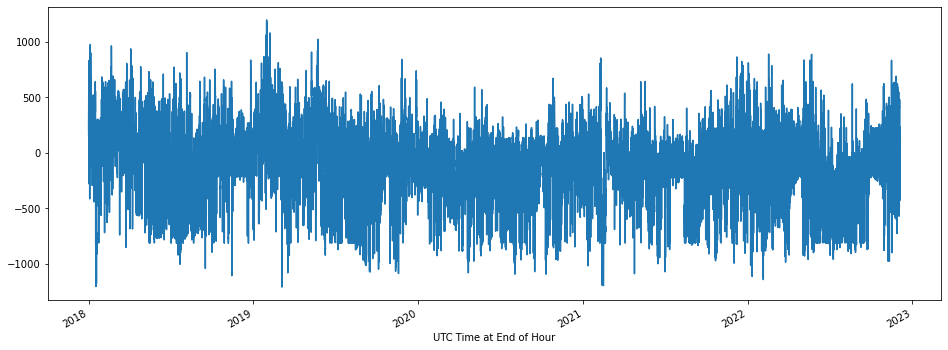

In [48]:
inter = texas['Total Interchange (MW)']
inter.plot(figsize=(16,6))

### Interchange check individual years

## Downsampling 

In [64]:
daily = inter.resample('D').mean()

<AxesSubplot:xlabel='UTC Time at End of Hour'>

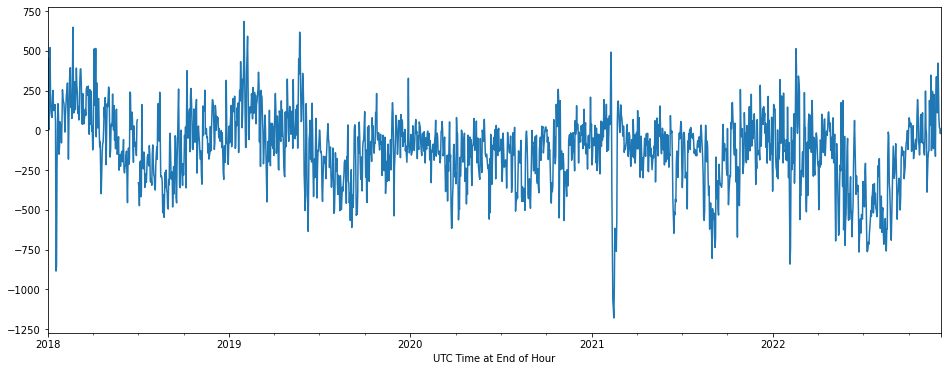

In [65]:
daily.plot(figsize=(16,6))

In [106]:
daily = pd.DataFrame(daily)
daily.loc[daily['Total Interchange (MW)'] == np.nan]

,Total Interchange (MW)
UTC Time at End of Hour,


### Baseline model

In [107]:
cutoff = round(inter.shape[0]*0.8)
cutoff

train = inter[:cutoff]

test = inter[cutoff:]

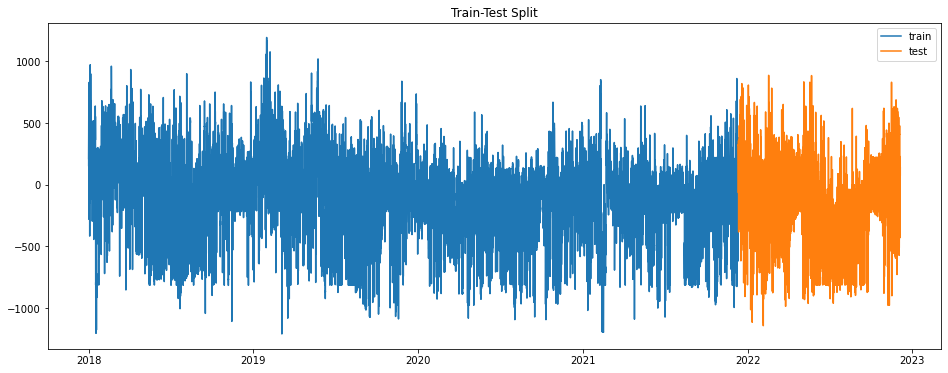

In [118]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

In [108]:
split = TimeSeriesSplit()

In [109]:
train.isna().sum()

0

In [110]:
naive = train.shift(1)
naive

UTC Time at End of Hour
2018-01-01 07:00:00      NaN
2018-01-01 08:00:00    212.0
2018-01-01 09:00:00    385.0
2018-01-01 10:00:00    150.0
2018-01-01 11:00:00    398.0
                       ...  
2021-12-11 03:00:00    157.0
2021-12-11 04:00:00    244.0
2021-12-11 05:00:00    301.0
2021-12-11 06:00:00    381.0
2021-12-11 07:00:00    172.0
Name: Total Interchange (MW), Length: 34460, dtype: float64

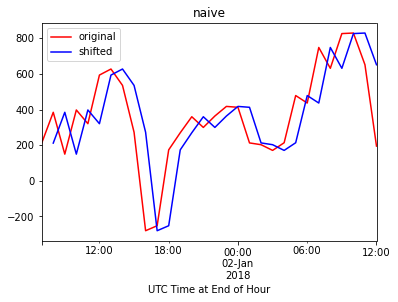

In [111]:
fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
naive[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

In [112]:
np.sqrt(mean_squared_error(train[1:], naive.dropna()))

139.15993916243295

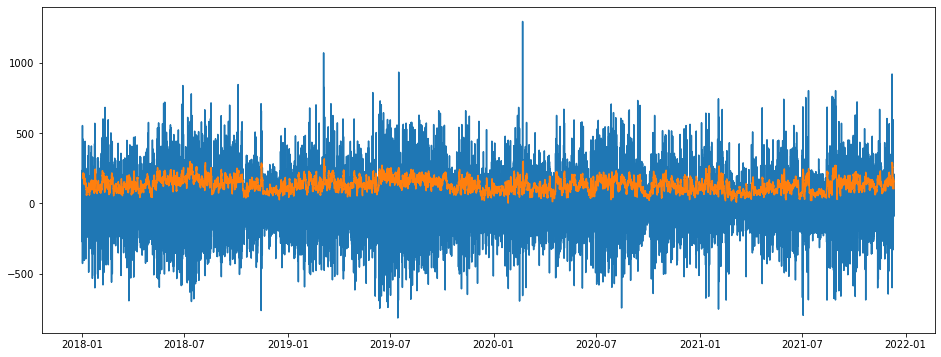

In [115]:
fig, ax = plt.subplots(figsize = (16,6))
residuals = naive[1:] - train[1:]
ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(30).std());

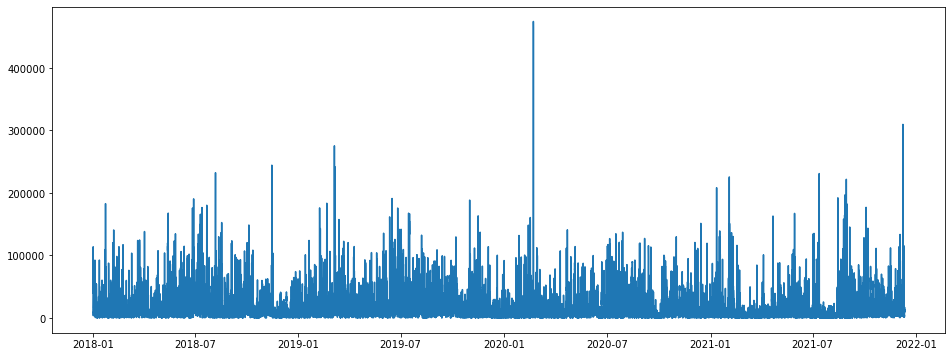

In [116]:
fig, ax = plt.subplots(figsize = (16,6))

ax.plot(residuals.index, residuals.rolling(6).var());

In [ ]:
smx = sarimax.SARIMAX(interFloat, order=(1,0,1), seasonal_order=(1,0,1,24)).fit()